# Import necessary libraries

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import LeavePGroupsOut
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Functions

In [3]:
def train_test_split_per_user(data, train_size=0.8, target_column='label_negative_affect_category'):
    users = list(set(data.id))
    users = sorted(users, reverse=True)  
    total_users = len(users)
    slice_idx = int(train_size * total_users)
    users_train = users[:slice_idx]
    users_test = users[slice_idx:]
    
    # Split data based on user IDs
    train_data = data[data.id.isin(users_train)]
    test_data = data[data.id.isin(users_test)]
    
    x_train = train_data.drop(['id', target_column], axis=1) 
    y_train = train_data[target_column]  
    x_test = test_data.drop(['id', target_column], axis=1) 
    y_test = test_data[target_column]  
    
    return x_train, y_train, x_test, y_test

In [4]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Read the data

In [5]:
df = pd.read_pickle('../data/lifesnaps/lifesnapsv2.pkl')
df['id'] = df['id'].astype(str)
df = df[df['label_stress_sema'].notna()]
df = df.drop(columns=['label_panas_negative_affect', 'label_stai_stress'])
df

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,...,bmi,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,label_stress_sema
1,621e30e467b776a240e817c7,33.274919,52.5365,38.1610,94.5,17.2,72.0,0.733333,0.7,0.700000,...,3,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428,1.0
6,621e32af67b776a24045b4cf,34.119702,51.6220,43.5360,97.8,13.8,72.0,0.733333,0.7,0.700000,...,1,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428,0.0
8,621e301e67b776a240608a72,34.710232,62.3900,34.0570,96.0,15.0,74.0,0.700000,0.7,0.700000,...,1,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428,0.0
9,621e337667b776a240ce78ab,33.662874,52.9270,39.9390,95.5,11.2,72.0,0.733333,0.7,0.700000,...,1,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428,0.0
17,621e2f7a67b776a240f14425,32.556993,62.3900,34.0570,96.7,15.0,72.0,0.733333,0.7,0.700000,...,1,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4873,621e33cf67b776a240087de9,33.892631,62.8590,49.3950,96.0,12.0,72.0,0.733333,0.7,0.766667,...,2,0.866025,-0.781831,0.587785,-0.101168,0.5,0.62349,0.809017,-0.994869,1.0
4888,621e346f67b776a24081744f,32.903545,71.8630,25.4750,96.0,18.2,72.0,0.733333,0.7,0.733333,...,3,0.866025,0.000000,0.809017,-0.299363,0.5,1.00000,0.587785,-0.954139,1.0
4891,621e2f9167b776a240011ccb,34.716690,58.4890,28.3290,96.5,14.2,72.0,0.733333,0.7,0.700000,...,1,0.866025,0.000000,0.809017,-0.299363,0.5,1.00000,0.587785,-0.954139,1.0
4900,621e331067b776a24085dd3f,34.683800,62.3900,34.0570,96.0,15.0,72.0,0.733333,0.7,0.700000,...,1,0.866025,0.000000,0.809017,-0.299363,0.5,1.00000,0.587785,-0.954139,0.0


In [6]:
df.columns

Index(['id', 'nightly_temperature', 'nremhr', 'rmssd', 'spo2',
       'full_sleep_breathing_rate', 'stress_score', 'sleep_points_percentage',
       'exertion_points_percentage', 'responsiveness_points_percentage',
       'daily_temperature_variation', 'calories', 'filteredDemographicVO2Max',
       'distance', 'bpm', 'lightly_active_minutes',
       'moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes',
       'scl_avg', 'resting_hr', 'sleep_duration', 'minutesAsleep',
       'minutesAwake', 'sleep_efficiency', 'sleep_deep_ratio',
       'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps',
       'minutes_in_default_zone_1', 'minutes_below_default_zone_1', 'age',
       'gender', 'bmi', 'month_sin', 'weekday_sin', 'week_sin', 'day_sin',
       'month_cos', 'weekday_cos', 'week_cos', 'day_cos', 'label_stress_sema'],
      dtype='object')

In [7]:
df['label_stress_sema'].value_counts()

0.0    1750
1.0     496
Name: label_stress_sema, dtype: int64

In [8]:
features = ['nightly_temperature', 'nremhr', 'rmssd', 'spo2', 'full_sleep_breathing_rate', 'stress_score', 'sleep_points_percentage', 'exertion_points_percentage', 'responsiveness_points_percentage', 'daily_temperature_variation', 'calories', 'filteredDemographicVO2Max', 'distance', 'bpm', 'lightly_active_minutes','moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes', 'scl_avg', 'resting_hr', 'sleep_duration', 'minutesAsleep', 'minutesAwake', 'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps', 'minutes_in_default_zone_1', 'minutes_below_default_zone_1', 'month_sin', 'weekday_sin', 'week_sin', 'day_sin', 'month_cos', 'weekday_cos', 'week_cos', 'day_cos']

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Generic Model
each user belongs to either the train or the test set

In [9]:
X_train, y_train, X_test, y_test = train_test_split_per_user(df,target_column='label_stress_sema')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

(1682, 42) (1682,) (564, 42) (564,)


Dummy f1 score: 0.7553191489361702


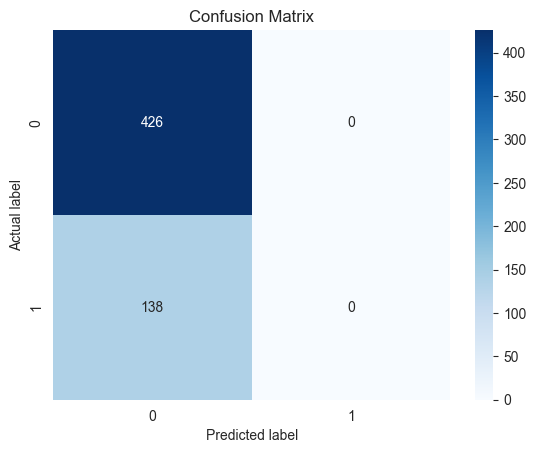

In [11]:
# Dummy Classifier for comparison
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_smote, y_train_smote)
dummy_predictions = dummy_clf.predict(X_test)

f1 = f1_score(y_test, dummy_predictions, average='micro')
print(f'Dummy f1 score: {f1}')
plot_confusion_matrix(y_test, dummy_predictions)

In [41]:
clf = SVC(probability=True)
#clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf = XGBClassifier(n_estimators=100, random_state=42)
#clf = GradientBoostingClassifier(n_estimators=160, learning_rate=0.3, random_state=42)
#clf = LogisticRegression(max_iter=200, random_state=42)

In [42]:
clf.fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='micro')
print(f"F1 Score: {f1}")
print(confusion_matrix(y_test, y_pred))

F1 Score: 0.6560283687943262
[[346  80]
 [114  24]]


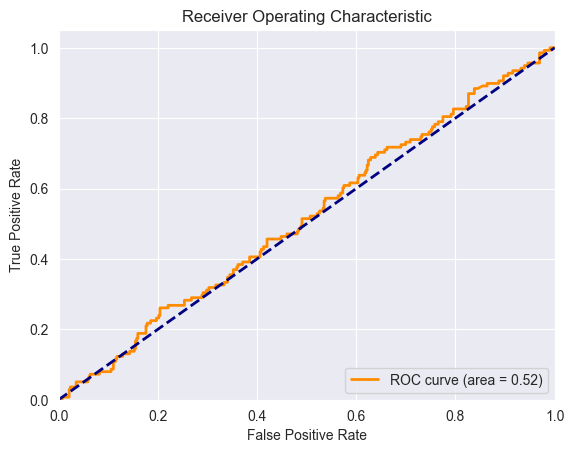

In [43]:
# Predict probabilities
y_scores = clf.predict_proba(X_test)[:, 0]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Leave one person out (LOPO) method

In [56]:
X = df.drop(['label_stress_sema', 'id'], axis=1)  # Features
y = df['label_stress_sema']  # Target variable
unique_labels = y.unique()
groups = df['id']  # Group identifier for LOPO

model = DummyClassifier(strategy='most_frequent')
#model = SVC()
#model = RandomForestClassifier(n_estimators=100, random_state=42)
#model = XGBClassifier(n_estimators=100, random_state=42)
#model = GradientBoostingClassifier(n_estimators=160, learning_rate=0.3, random_state=42)
#model = LogisticRegression(random_state=42)

cv = LeavePGroupsOut(n_groups=1)
scores = []
confusion_matrices = []

for train_idx, test_idx in cv.split(X, y, groups):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='micro')
    scores.append(score)
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    confusion_matrices.append(cm)

# Calculate the average performance across all LOPO iterations
average_score = np.mean(scores)
print(f'Average f1-scores across all LOPO iterations: {average_score}')
total_confusion_matrix = np.sum(confusion_matrices, axis=0)
print(total_confusion_matrix)

Average f1-scores across all LOPO iterations: 0.7719036252885709
[[   0  496]
 [   0 1750]]


# Deep Learning

In [ ]:
X_train, y_train, X_test, y_test = train_test_split_per_user(df,target_column='label_stress_sema')

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

mlp = MLPClassifier(random_state=42, max_iter=800)
#mlp = MLPClassifier(max_iter=1000, activation = 'relu', alpha=0.001, hidden_layer_sizes=(50,), random_state=42)
mlp.fit(X_train_smote, y_train_smote)

y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)[:, 1]  # Get probability for the positive class

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()